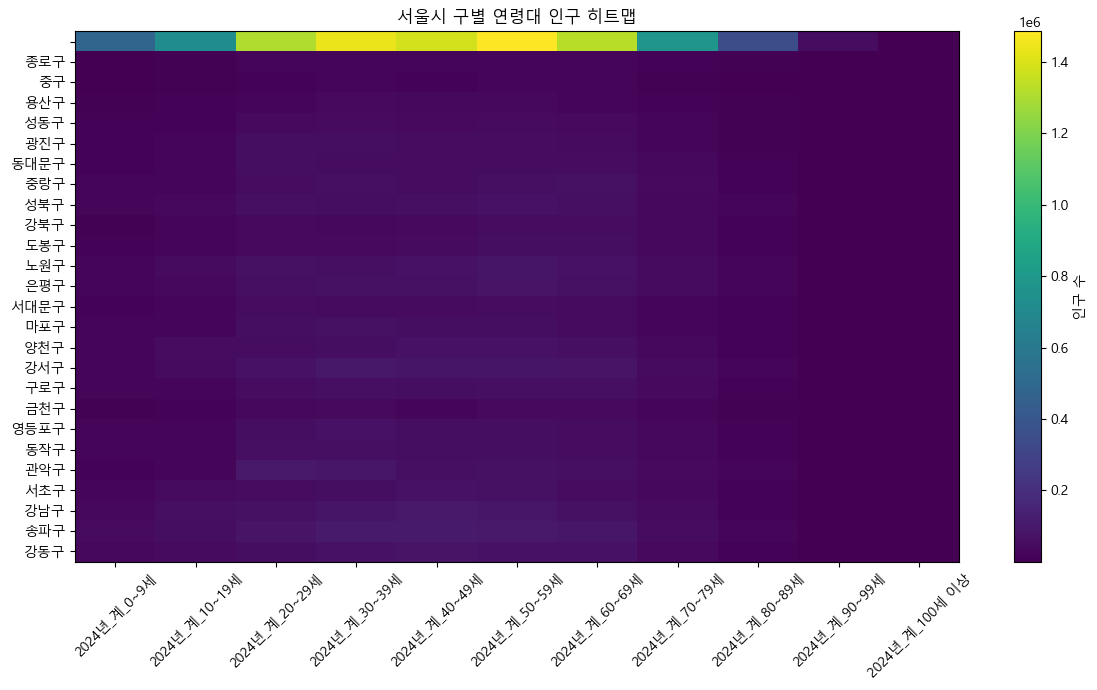

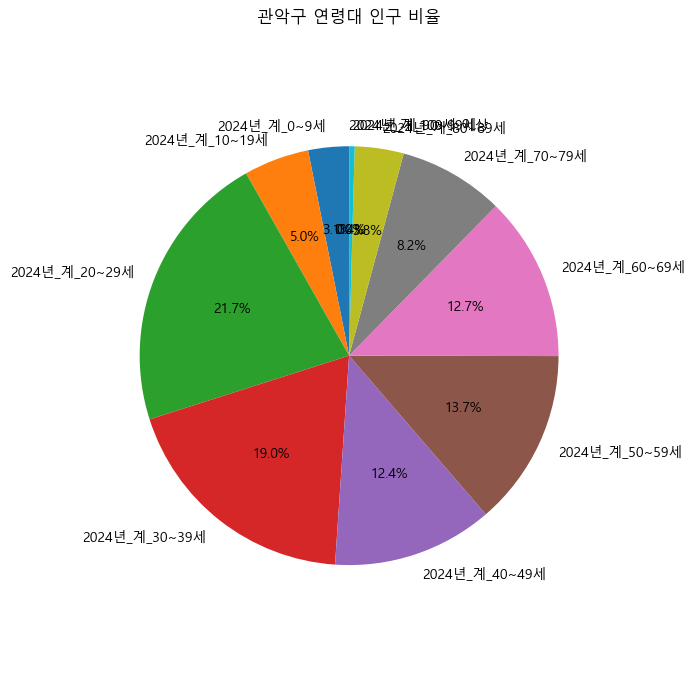

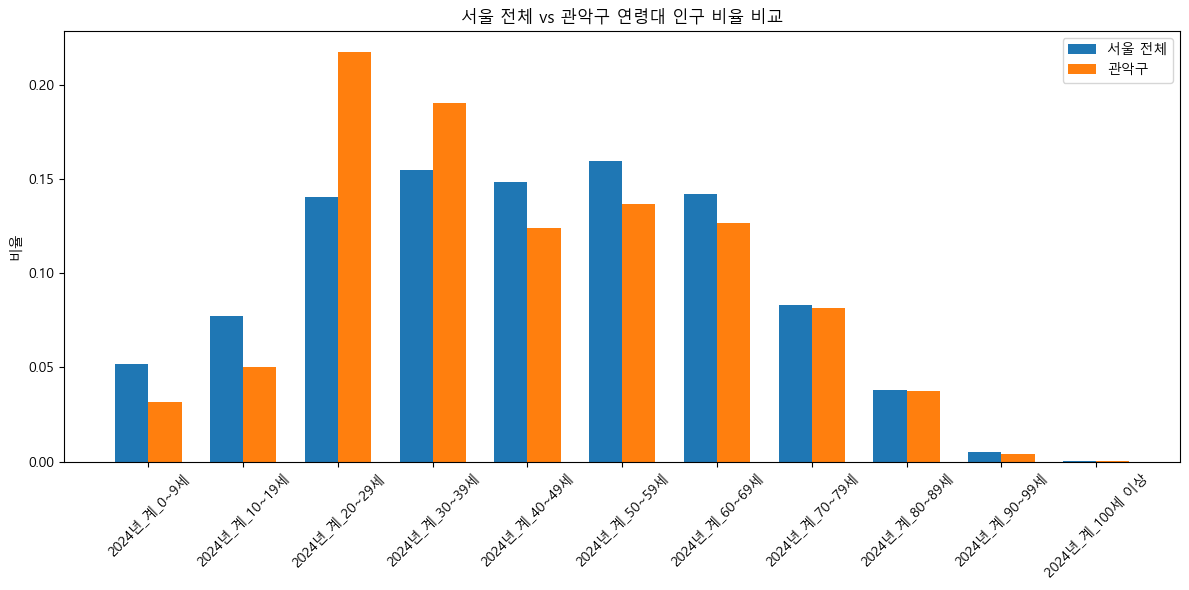

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import platform

# ======================
# 0. 한글 폰트 설정
# ======================
system = platform.system()
if system == "Windows":
    plt.rcParams["font.family"] = "Malgun Gothic"
elif system == "Darwin":
    plt.rcParams["font.family"] = "AppleGothic"
else:
    plt.rcParams["font.family"] = "NanumGothic"

plt.rcParams["axes.unicode_minus"] = False

# ======================
# 1. 데이터 불러오기
# ======================
seoul = pd.read_csv("datas/서울시_연령별.csv", encoding="cp949")
gwanak = pd.read_csv("datas/관악구_연령별.csv", encoding="cp949")

# ======================
# 2. 연령대 컬럼 자동 추출
#    (총인구수, 연령구간 합계는 제외)
# ======================
age_cols = [
    col for col in seoul.columns
    if "2024년_계_" in col
    and "총인구수" not in col
    and "연령구간" not in col
]

# ======================
# 3. 서울시: '구'만 추출해서 피벗 만들기
# ======================
# 행정구역 예: "서울특별시 관악구 (1162000000)" 또는 "서울특별시 관악구 신림동(1162058500)"
# 구 이름만 뽑기: 두 번째 토큰 + 괄호 앞까지
def extract_gu(name):
    # "서울특별시 관악구 (1162000000)" → ["서울특별시", "관악구", "(1162000000)"]
    parts = str(name).split()
    if len(parts) < 2:
        return name
    gu = parts[1]
    # "관악구(1162000000)" 같은 경우 괄호 제거
    gu = gu.split("(")[0]
    return gu

seoul["구"] = seoul["행정구역"].apply(extract_gu)

pivot = seoul.set_index("구")[age_cols]

# ======================
# 4. 숫자형으로 깔끔하게 변환 (여기가 핵심!!!)
# ======================
# 콤마 제거 후 float 변환
pivot_num = (
    pivot
    .astype(str)
    .replace(",", "", regex=True)
    .astype(float)
)

# 서울 전체 연령대 합계도 숫자로 변환
seoul_total = (
    seoul[age_cols]
    .astype(str)
    .replace(",", "", regex=True)
    .astype(float)
    .sum()
)

# 관악구 연령대 (관악구 전체 합계 행만 사용)
gwanak_row = gwanak[gwanak["행정구역"].str.contains("서울특별시 관악구  \(1162000000\)", regex=True, na=False)]
if gwanak_row.empty:
    # 혹시 위 정규식이 안 맞으면, 관악구 전체(첫 행) 기준으로 사용
    gwanak_row = gwanak.iloc[[0]]

gwanak_age = (
    gwanak_row[age_cols]
    .iloc[0]                 # 시리즈 하나만
    .astype(str)
    .replace(",", "", regex=True)
    .astype(float)
)

# ======================
# 5. 히트맵 - 서울시 구별 연령대 분포
# ======================
plt.figure(figsize=(12, 7))
plt.imshow(pivot_num.values, aspect="auto")  # ★ pivot_num.values (float) 사용
plt.colorbar(label="인구 수")
plt.xticks(range(len(age_cols)), age_cols, rotation=45)
plt.yticks(range(len(pivot_num.index)), pivot_num.index)
plt.title("서울시 구별 연령대 인구 히트맵")
plt.tight_layout()
plt.show()

# ======================
# 6. 관악구 연령대 파이차트
# ======================
plt.figure(figsize=(7, 7))
plt.pie(
    gwanak_age.values,       # float series
    labels=age_cols,
    autopct="%1.1f%%",
    startangle=90
)
plt.title("관악구 연령대 인구 비율")
plt.axis("equal")
plt.tight_layout()
plt.show()

# ======================
# 7. 서울 전체 vs 관악구 연령 비율 비교 바차트
# ======================
seoul_ratio = seoul_total / seoul_total.sum()
gwanak_ratio = gwanak_age / gwanak_age.sum()

x = np.arange(len(age_cols))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, seoul_ratio.values, width, label="서울 전체")
plt.bar(x + width/2, gwanak_ratio.values, width, label="관악구")
plt.xticks(x, age_cols, rotation=45)
plt.ylabel("비율")
plt.title("서울 전체 vs 관악구 연령대 인구 비율 비교")
plt.legend()
plt.tight_layout()
plt.show()
